<a href="https://colab.research.google.com/github/daniellcosmo/CBM_Naval_Propulsion_Plant/blob/main/CBM_Naval_Propulsion_Plant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema

Datase: http://archive.ics.uci.edu/ml/datasets/condition+based+maintenance+of+naval+propulsion+plants


y1 [GT Compressor decay state coefficient] <br>
y2 [GT Turbine decay state coefficient]


#Importação dos Dados

In [ ]:
%pip install optuna
%pip install bayesian-optimization

In [6]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import time
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import GridSearchCV
import optuna
from optuna.samplers import TPESampler

In [7]:
path = 'https://raw.githubusercontent.com/daniellcosmo/CBM_Naval_Propulsion_Plant/main/dataset/'
df = pd.read_csv(path + 'data.txt', sep="   ", header=None, engine='python')

Features = [
 'lever_position',
 'ship_speed',
 'GT_shaft_torque',
 'GT_rpm',
 'GG_rpm',
 'S_prplr_torque',
 'P_prplr_torque',
 'HP_T_exit_temp',
 'GT_C_airIn_temp',
 'GT_C_airOut_temp',
 'HP_T_exit_pressure',
 'GT_C_airIn_pressure',
 'GT_C_airOut_pressure',
 'GT_exhGas_pressure',
 'T_inj_control',
 'fuel_flow',
 'GT_C_decay_coef',
 'GT_T_decay_coef']
df.columns = Features
df.head()

,lever_position,ship_speed,GT_shaft_torque,GT_rpm,GG_rpm,S_prplr_torque,P_prplr_torque,HP_T_exit_temp,GT_C_airIn_temp,GT_C_airOut_temp,HP_T_exit_pressure,GT_C_airIn_pressure,GT_C_airOut_pressure,GT_exhGas_pressure,T_inj_control,fuel_flow,GT_C_decay_coef,GT_T_decay_coef
0,1.138,3.0,289.964,1349.489,6677.380,7.584,7.584,464.006,288.0,550.563,1.096,0.998,5.947,1.019,7.137,0.082,0.95,0.975
1,2.088,6.0,6960.180,1376.166,6828.469,28.204,28.204,635.401,288.0,581.658,1.331,0.998,7.282,1.019,10.655,0.287,0.95,0.975
2,3.144,9.0,8379.229,1386.757,7111.811,60.358,60.358,606.002,288.0,587.587,1.389,0.998,7.574,1.020,13.086,0.259,0.95,0.975
3,4.161,12.0,14724.395,1547.465,7792.630,113.774,113.774,661.471,288.0,613.851,1.658,0.998,9.007,1.022,18.109,0.358,0.95,0.975
4,5.140,15.0,21636.432,1924.313,8494.777,175.306,175.306,731.494,288.0,645.642,2.078,0.998,11.197,1.026,26.373,0.522,0.95,0.975


In [ ]:
with open(path + "Features.txt", 'r') as f:
  lines = f.readlines() 

FeaturesNames = []
for i in range(0, len(lines)):
    FeaturesNames.append(lines[i].rstrip('\n'))

FeaturesNames

['1 - Lever position (lp) [ ]',
 '2 - Ship speed (v) [knots]',
 '3 - Gas Turbine shaft torque (GTT) [kN m]',
 '4 - Gas Turbine rate of revolutions (GTn) [rpm]',
 '5 - Gas Generator rate of revolutions (GGn) [rpm]',
 '6 - Starboard Propeller Torque (Ts) [kN]',
 '7 - Port Propeller Torque (Tp) [kN]',
 '8 - HP Turbine exit temperature (T48) [C]',
 '9 - GT Compressor inlet air temperature (T1) [C]',
 '10 - GT Compressor outlet air temperature (T2) [C]',
 '11 - HP Turbine exit pressure (P48) [bar]',
 '12 - GT Compressor inlet air pressure (P1) [bar]',
 '13 - GT Compressor outlet air pressure (P2) [bar]',
 '14 - Gas Turbine exhaust gas pressure (Pexh) [bar]',
 '15 - Turbine Injecton Control (TIC) [%]',
 '16 - Fuel flow (mf) [kg/s]',
 '17 - GT Compressor decay state coefficient.',
 '18 - GT Turbine decay state coefficient. ']

#2. Análise dos Dados

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lever_position        11934 non-null  float64
 1   ship_speed            11934 non-null  float64
 2   GT_shaft_torque       11934 non-null  float64
 3   GT_rpm                11934 non-null  float64
 4   GG_rpm                11934 non-null  float64
 5   S_prplr_torque        11934 non-null  float64
 6   P_prplr_torque        11934 non-null  float64
 7   HP_T_exit_temp        11934 non-null  float64
 8   GT_C_airIn_temp       11934 non-null  float64
 9   GT_C_airOut_temp      11934 non-null  float64
 10  HP_T_exit_pressure    11934 non-null  float64
 11  GT_C_airIn_pressure   11934 non-null  float64
 12  GT_C_airOut_pressure  11934 non-null  float64
 13  GT_exhGas_pressure    11934 non-null  float64
 14  T_inj_control         11934 non-null  float64
 15  fuel_flow          

In [ ]:
df.describe()

,lever_position,ship_speed,GT_shaft_torque,GT_rpm,GG_rpm,S_prplr_torque,P_prplr_torque,HP_T_exit_temp,GT_C_airOut_temp,HP_T_exit_pressure,GT_C_airOut_pressure,GT_exhGas_pressure,T_inj_control,fuel_flow,GT_C_decay_coef,GT_T_decay_coef
count,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.00000,11934.0000
mean,5.166667,15.000000,27247.498685,2136.289256,8200.947312,227.335768,227.335768,735.495446,646.215331,2.352963,12.297123,1.029474,33.641261,0.662440,0.97500,0.9875
std,2.626388,7.746291,22148.613155,774.083881,1091.315507,200.495889,200.495889,173.680552,72.675882,1.084770,5.337448,0.010390,25.841363,0.507132,0.01472,0.0075
min,1.138000,3.000000,253.547000,1307.675000,6589.002000,5.304000,5.304000,442.364000,540.442000,1.093000,5.828000,1.019000,0.000000,0.068000,0.95000,0.9750
25%,3.144000,9.000000,8375.883750,1386.758000,7058.324000,60.317000,60.317000,589.872750,578.092250,1.389000,7.447250,1.020000,13.677500,0.246000,0.96200,0.9810
50%,5.140000,15.000000,21630.659000,1924.326000,8482.081500,175.268000,175.268000,706.038000,637.141500,2.083000,11.092000,1.026000,25.276500,0.496000,0.97500,0.9875
75%,7.148000,21.000000,39001.426750,2678.079000,9132.606000,332.364750,332.364750,834.066250,693.924500,2.981000,15.658000,1.036000,44.552500,0.882000,0.98800,0.9940
max,9.300000,27.000000,72784.872000,3560.741000,9797.103000,645.249000,645.249000,1115.797000,789.094000,4.560000,23.140000,1.052000,92.556000,1.832000,1.00000,1.0000


##BoxPlot Normalizado

In [ ]:
x = df.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_df = pd.DataFrame(x_scaled)
normalized_df.columns = Features

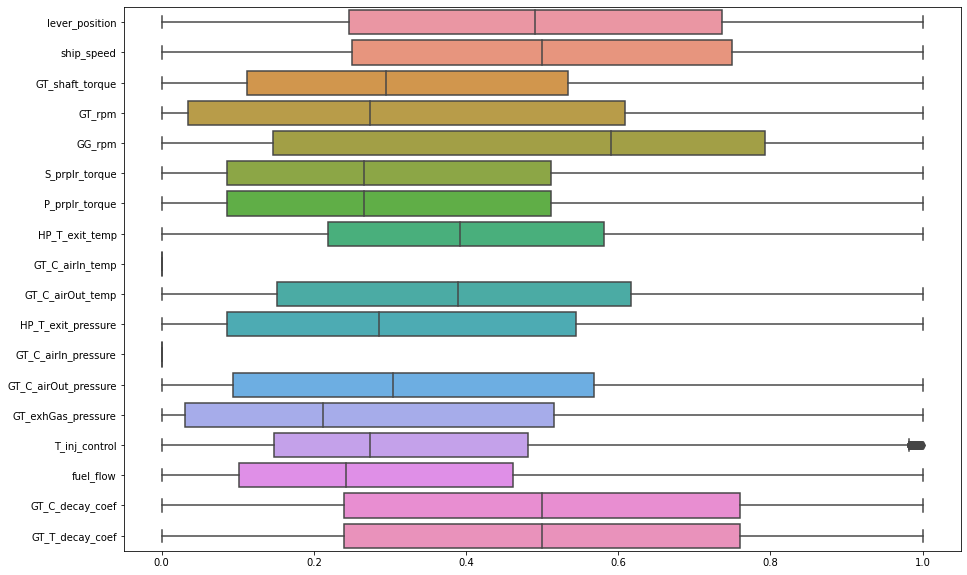

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
_= sns.boxplot(data=normalized_df, dodge=False, orient="h")

Como é possível visualizar, as features: 
*   GT_C__airIn_pressure; e
*   GT_C__airIn_temp

possuem std igual a zero, comportando-se como constante sem fazer um impacto no resultado final.
<br>
Dado isso, podemos removê-las do modelo.

In [8]:
try:
  f1 = 'GT_C_airIn_temp'
  f2 = 'GT_C_airIn_pressure'
  df=df.drop(f1, axis=1)
  print('Removida feature ', f1)
  df=df.drop(f2, axis=1)
  print('Removida feature ', f2)
except Exception:
  print('Feature(s) já não se encontram no DataFrame')
  pass

Removida feature  GT_C_airIn_temp
Removida feature  GT_C_airIn_pressure


##Histograma de Frequências e Distribuição Normal

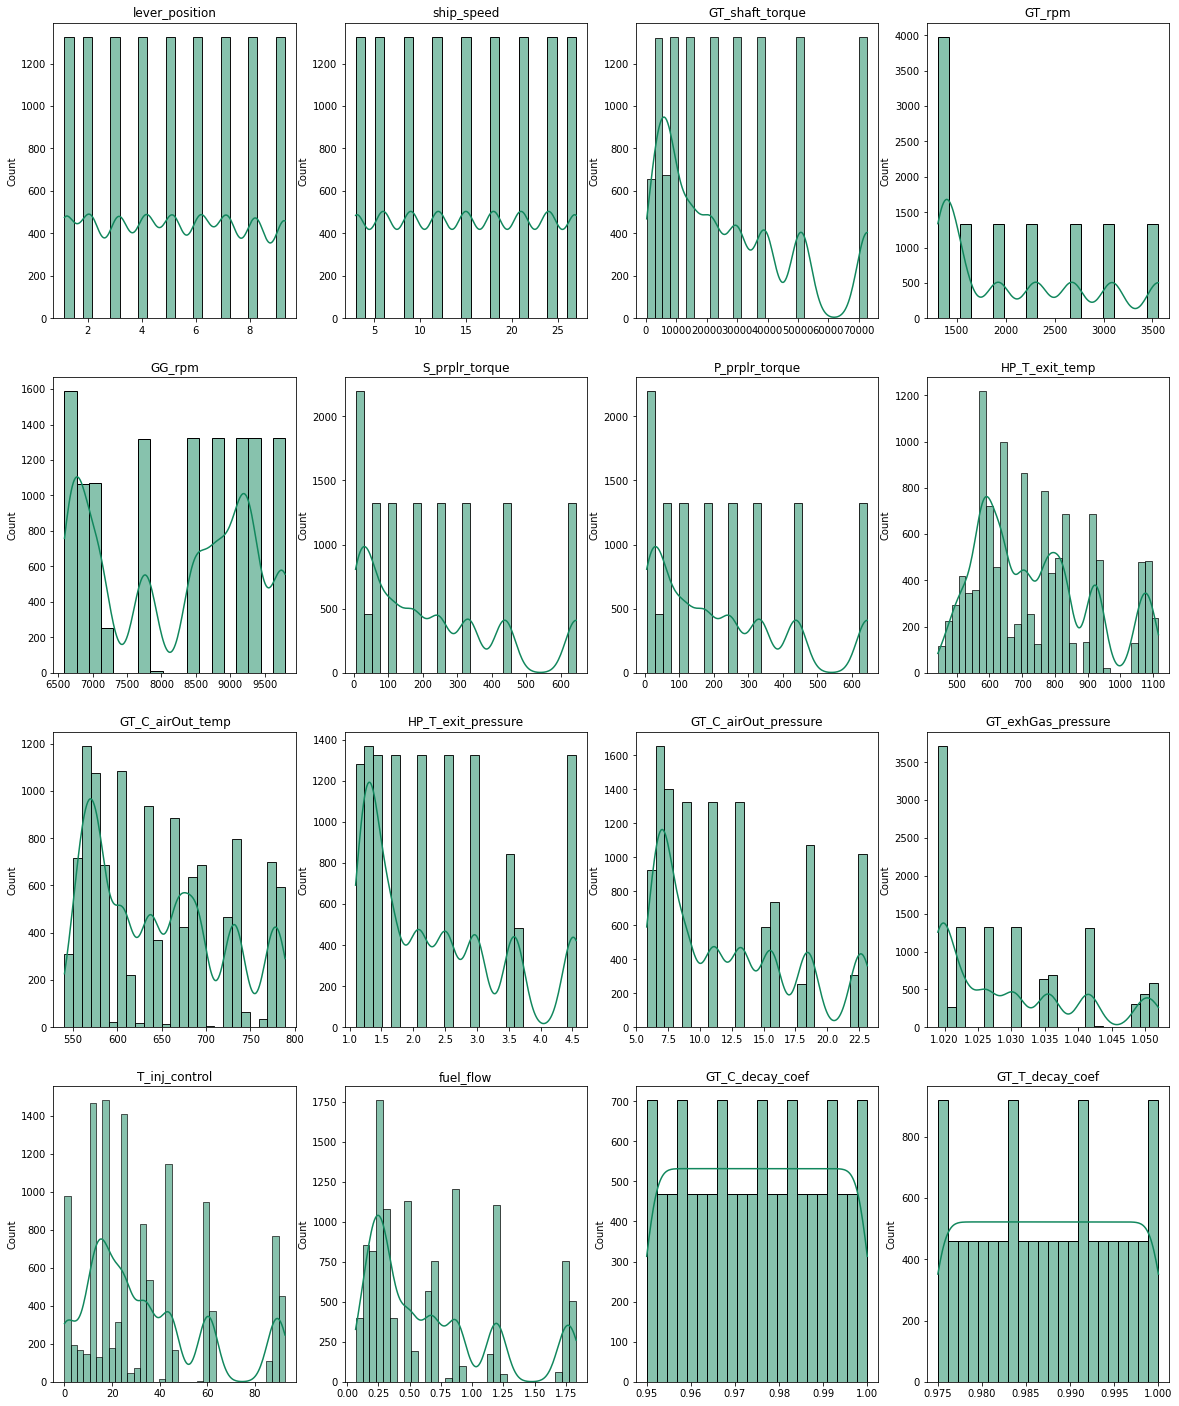

In [ ]:
# sns.displot(df['lever_position'], kde=True)
# https://www.biomooc.com/color/seabornColors.html

fig, axes = plt.subplots(nrows = 4, ncols = 4)    # axes is 2d array (4x4)
axes = axes.flatten()         # Convert axes to 1d array of length nrows x rcols
fig.set_size_inches(20, 25)

for ax, col in zip(axes, df.columns):
  sns.histplot(df[col], ax = ax, kde=True, color=sns.xkcd_rgb['dark sea green'], label="Compact").set(xlabel=None)
  ax.set_title(col)



##Teste de Normalidade de Kolmogorov-Smirnov



In [ ]:
testeNormal = pd.DataFrame(index=[ "Segue Distribuição Normal?"])

for col in df.columns:
    stat,p= stats.normaltest(df[col])
    if p<=0.05:
        testeNormal[col] = 'Não'
    else:
        testeNormal[col] = 'Sim'

testeNormal = testeNormal.T
testeNormal

,Segue Distribuição Normal?
lever_position,Não
ship_speed,Não
GT_shaft_torque,Não
GT_rpm,Não
GG_rpm,Não
S_prplr_torque,Não
P_prplr_torque,Não
HP_T_exit_temp,Não
GT_C_airOut_temp,Não
HP_T_exit_pressure,Não


Ou seja, o valor-p foi menor do que nosso nível de significância, logo, a probabilidade de obtermos dados como estes é muito pequena. Assim, podemos concluir que os valores não seguem distribuição normal.

## Heatmap

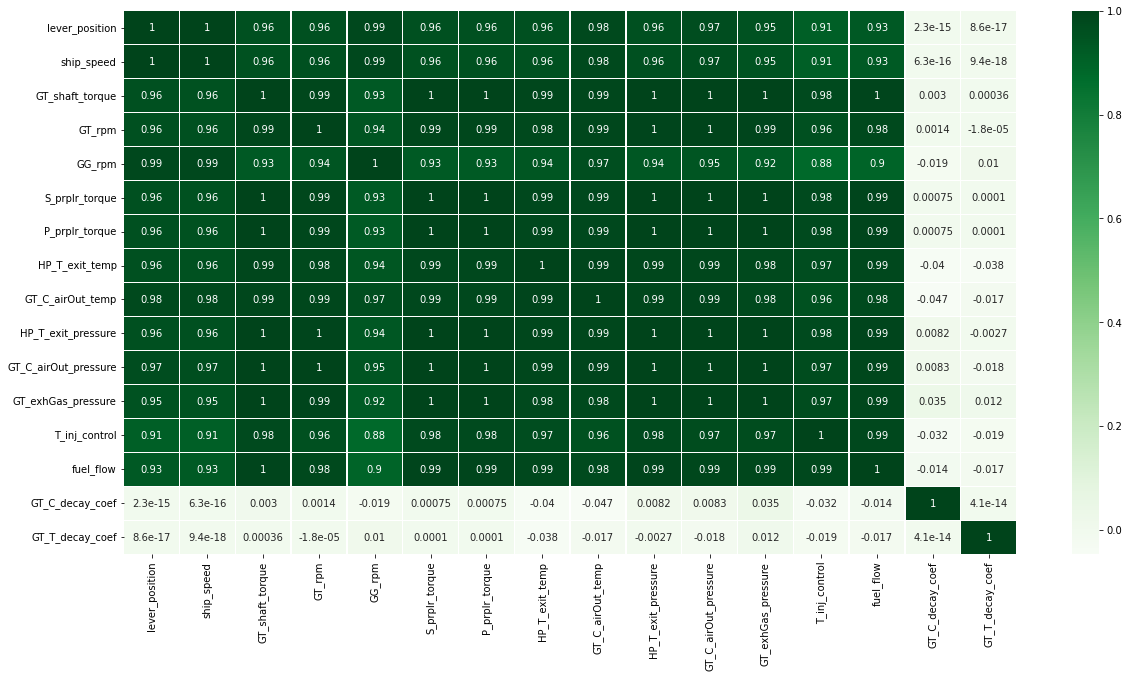

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
_= sns.heatmap(df.corr(), cmap = 'Greens', linewidth=0.5, annot=True)

Como as features tem uma alta correlação entre elas e uma baixa entre as respostas podemos assumir que as features e as respostas possuem uma não-linearidade entre si. 

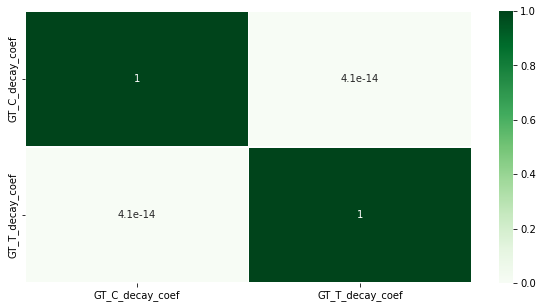

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
_= sns.heatmap(df.iloc[: , -2:].corr(), cmap = 'Greens', linewidth=0.5, annot=True)

Como as respostas também possuem uma baixa correlação entre si, iremos considerá-las independentes, com isso, usá-las em treinos diferentes

#Divisão de Dados

## Features e Targets

In [9]:
X = df.iloc[: , :-2]
y1 = df['GT_C_decay_coef']
y2 = df['GT_T_decay_coef']


## Treino e Teste

In [10]:
x1_train,x1_test,y1_train,y1_test = train_test_split(X,y1)
x2_train,x2_test,y2_train,y2_test = train_test_split(X,y2)

# Modelagem e Inferência

## Sugestão de Modelos

* Support Vector Machine Regression; OK
* k-NN; OK
* Decision Tree Regression; OK
* BaggingRegressor; OK
* XGBRegressor; OK
<br><br>
* Neural Net;
* Deep Learning;
<br>


## Modelos Candidatos e Métricas

In [11]:
models = {'SVR' : SVR(),
          'KNeighborsRegressor': KNeighborsRegressor(), 
          'DecisionTreeRegressor': DecisionTreeRegressor(), 
          'BaggingRegressor': BaggingRegressor(), 
          'XGBRegressor': XGBRegressor()}

In [12]:
def train_models(x_train, y_train, x_test, y_test, models):
  y_info = pd.DataFrame(columns=['Model','Train Time', 'Mean Absolute Error', 'Mean Absolute Percentual Error', 'Mean Squared  Error',
                                 'Root Mean Squared  Error','Train Accuracy (R²)', 'Test Accuracy (R²)', 'Y Predicted Test'], 
                       index = models.keys())
  y_preds = models
  for i, model in enumerate(models.keys()):
    start_time = time.perf_counter()
    y_info.loc[y_info.index[i], 'Model'] = models[model].fit(x_train, y_train)
    y_info.loc[y_info.index[i], 'Train Time'] = time.perf_counter() - start_time
    y_pred = models[model].predict(x_test)

    y_info.loc[y_info.index[i], 'Train Accuracy (R²)'] = models[model].score(x_train, y_train)
    y_info.loc[y_info.index[i], 'Test Accuracy (R²)'] = models[model].score(x_test, y_test)
    y_info.loc[y_info.index[i], 'Mean Absolute Error'] = mean_absolute_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Absolute Percentual Error'] = metrics.mean_absolute_percentage_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Squared  Error'] = mean_squared_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Root Mean Squared  Error'] = np.sqrt(mean_squared_error(y_test, y_pred))
    y_info.loc[y_info.index[i], 'Y Predicted Test'] = y_pred

  return y_info

## Modelos sem Redução de Dimensionalidade

### Modelos para y1

In [9]:
y1_models = train_models(x1_train, y1_train, x1_test, y1_test, models)
y1_models.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

[22:04:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train Time,Mean Absolute Error,Mean Absolute Percentual Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy (R²),Test Accuracy (R²)
SVR,0.012494,0.012756,0.013089,0.000217,0.014745,-0.000009,-0.000083
KNeighborsRegressor,0.016929,0.001357,0.001398,0.000013,0.003653,0.960744,0.938605
DecisionTreeRegressor,0.12593,0.000975,0.001001,0.000002,0.001554,1.0,0.988892
BaggingRegressor,0.794519,0.000565,0.00058,0.000001,0.000994,0.998805,0.995456
XGBRegressor,0.862593,0.003023,0.003103,0.000017,0.004063,0.929382,0.924057


### Modelos para y2

In [ ]:
y2_models = train_models(x2_train, y2_train, x2_test, y2_test, models)
y2_models.drop(['Model'], axis=1)

[14:21:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train Time,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy,Test Accuracy
SVR,0.005996,0.006579,0.000057,0.007561,-0.000117,-0.001028
KNeighborsRegressor,0.012372,0.001097,0.000007,0.002619,0.928135,0.879916
DecisionTreeRegressor,0.099394,0.000545,0.000002,0.001322,1.0,0.969389
BaggingRegressor,0.632735,0.000441,0.000001,0.000964,0.997092,0.983738
XGBRegressor,0.481458,0.002556,0.000011,0.00338,0.816078,0.799905


## Redução de Dimensionalidade

### Modelos usando Redução de Dimensionalidade por VIF (Sem PCA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lever_position        11934 non-null  float64
 1   ship_speed            11934 non-null  float64
 2   GT_shaft_torque       11934 non-null  float64
 3   GT_rpm                11934 non-null  float64
 4   GG_rpm                11934 non-null  float64
 5   S_prplr_torque        11934 non-null  float64
 6   P_prplr_torque        11934 non-null  float64
 7   HP_T_exit_temp        11934 non-null  float64
 8   GT_C_airOut_temp      11934 non-null  float64
 9   HP_T_exit_pressure    11934 non-null  float64
 10  GT_C_airOut_pressure  11934 non-null  float64
 11  GT_exhGas_pressure    11934 non-null  float64
 12  T_inj_control         11934 non-null  float64
 13  fuel_flow             11934 non-null  float64
 14  GT_C_decay_coef       11934 non-null  float64
 15  GT_T_decay_coef    

####Y1

Obtendo a correlação de cada feature com o respectivo target

In [13]:
df_corr_y1 = df.corr()['GT_C_decay_coef'].abs().sort_values(ascending=False)
df_corr_y1

GT_C_decay_coef         1.000000e+00
GT_C_airOut_temp        4.717657e-02
HP_T_exit_temp          3.962512e-02
GT_exhGas_pressure      3.528524e-02
T_inj_control           3.203662e-02
GG_rpm                  1.883800e-02
fuel_flow               1.366765e-02
GT_C_airOut_pressure    8.327871e-03
HP_T_exit_pressure      8.167586e-03
GT_shaft_torque         2.978258e-03
GT_rpm                  1.369908e-03
S_prplr_torque          7.535000e-04
P_prplr_torque          7.535000e-04
GT_T_decay_coef         4.064242e-14
lever_position          2.264405e-15
ship_speed              6.346298e-16
Name: GT_C_decay_coef, dtype: float64

Mantendo apenas as features que tem alta correlação relativa com o target <br>
Definindo o threshold para 0.6

In [14]:
features_y1 = df_corr_y1[df_corr_y1 > 1E-3].index.to_list()[1:]
features_y1

['GT_C_airOut_temp',
 'HP_T_exit_temp',
 'GT_exhGas_pressure',
 'T_inj_control',
 'GG_rpm',
 'fuel_flow',
 'GT_C_airOut_pressure',
 'HP_T_exit_pressure',
 'GT_shaft_torque',
 'GT_rpm']

Checando por MultiColinearidade

In [15]:
def calculate_vif(df, features):
  vif, tolerance = {}, {}

  # As features que queremos examinar
  for feature in features:

    # Extrair todos os outros recursos que iremos regress
    # 
    X_ = [f for f in features if f != feature]
    X_, y_ = df[X_], df[feature]

    # Extrair o r-squared do fit
    r2 = LinearRegression().fit(X_, y_).score(X_, y_)

    # Calcular a tolerância
    tolerance[feature] = 1 - r2

    # Calcular o VIF
    vif[feature] = 1/(tolerance[feature])

    # Retornar o VIF do DataFrame
  return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

calculated_vif_y1 = calculate_vif(df, features_y1).abs().sort_values(ascending=True, by=['VIF'])
calculated_vif_y1
  


,VIF,Tolerance
T_inj_control,42.164412,0.023717
GG_rpm,120.697885,0.008285
HP_T_exit_temp,285.371042,0.003504
GT_C_airOut_temp,540.845322,0.001849
GT_rpm,933.486623,0.001071
GT_exhGas_pressure,1174.156624,0.000852
fuel_flow,1445.078771,0.000692
GT_C_airOut_pressure,4237.105591,0.000236
GT_shaft_torque,5140.510091,0.000195
HP_T_exit_pressure,22654.117814,0.000044


Modelos usando features com VIF menor que 1000

In [13]:
features = calculated_vif_y1[calculated_vif_y1['VIF'] < 1000].index.to_list()
print('Features (VIF < 1000):\n', features)

# Treinando o Modelo com as Features Selecionadas
x1_train_1000 = x1_train.loc[:, features]
x1_test_1000 = x1_test.loc[:, features]

print('\nModelos:')
y1_models_1000 = train_models(x1_train_1000, y1_train, x1_test_1000, y1_test, models)
y1_models_1000.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 1000):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp', 'GT_C_airOut_temp', 'GT_rpm']

Modelos:
[22:05:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train Time,Mean Absolute Error,Mean Absolute Percentual Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy (R²),Test Accuracy (R²)
SVR,0.010417,0.012756,0.013089,0.000217,0.014745,-0.000009,-0.000083
KNeighborsRegressor,0.008036,0.000555,0.00057,0.000002,0.001317,0.995161,0.992019
DecisionTreeRegressor,0.0766,0.001094,0.001124,0.000006,0.002517,1.0,0.970864
BaggingRegressor,0.4925,0.000697,0.000715,0.000003,0.001836,0.997556,0.984497
XGBRegressor,0.442088,0.004542,0.004659,0.000036,0.006041,0.842067,0.832162


Modelos usando features com VIF menor que 500

In [16]:
features = calculated_vif_y1[calculated_vif_y1['VIF'] < 500].index.to_list()
print('Features (VIF < 500):\n', features)

# Treinando o Modelo com as Features Selecionadas
x1_train_500 = x1_train.loc[:, features]
x1_test_500 = x1_test.loc[:, features]

print('\nModelos:')
y1_models_500 = train_models(x1_train_500, y1_train, x1_test_500, y1_test, models)
y1_models_500.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

Features (VIF < 500):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']

Modelos:
[22:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train Time,Mean Absolute Error,Mean Absolute Percentual Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy (R²),Test Accuracy (R²)
SVR,0.007783,0.012835,0.013175,0.000219,0.014811,-0.00006,-0.000535
KNeighborsRegressor,0.007006,0.000716,0.000735,0.000004,0.001949,0.985414,0.982677
DecisionTreeRegressor,0.057209,0.00127,0.001305,0.000008,0.002763,1.0,0.965175
BaggingRegressor,0.363467,0.000819,0.00084,0.000004,0.002051,0.995896,0.980812
XGBRegressor,0.489217,0.005063,0.005193,0.000045,0.006712,0.810753,0.794485


Modelos usando features com VIF menor que 250

In [ ]:
features = calculated_vif_y1[calculated_vif_y1['VIF'] < 250].index.to_list()
print('Features (VIF < 250):\n', features)

# Treinando o Modelo com as Features Selecionadas
x1_train_250 = x1_train.loc[:, features]
x1_test_250 = x1_test.loc[:, features]

print('\nModelos:')
y1_models_250 = train_models(x1_train_250, y1_train, x1_test_250, y1_test, models)
y1_models_250.drop(['Model'], axis=1)

Features (VIF < 250):
 ['T_inj_control', 'GG_rpm']

Modelos:
[13:41:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train_Time,Train_Accuracy,Test_Accuracy
SVR,0.004065,-0.000003,-0.000026
KNeighborsRegressor,0.004617,0.941012,0.90785
DecisionTreeRegressor,0.036797,1.0,0.880725
BaggingRegressor,0.237319,0.986723,0.916373
XGBRegressor,0.282119,0.797089,0.774051


###PCA de todas as Features

Precisamos aplicar o Standardization antes de utilizar o PCA

In [ ]:
# Performing Standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

Analisando o Principal Component Analysis (PCA)

In [ ]:
components = None 
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X_scaled)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[9.75354433e+01 1.82261150e+00 2.48912686e-01 1.58823802e-01
 1.38784127e-01 6.88731250e-02 1.70245538e-02 5.12306744e-03
 2.32578917e-03 1.17974583e-03 6.84937966e-04 1.26871934e-04
 8.64557484e-05 3.19818638e-32]


* Vemos que o primeiro componentes captura 97.7% de variabilidade nos dados
* O segundo 1.8%
* Todos os componentes completam 100%

Text(0, 0.5, 'Explained variance (%)')

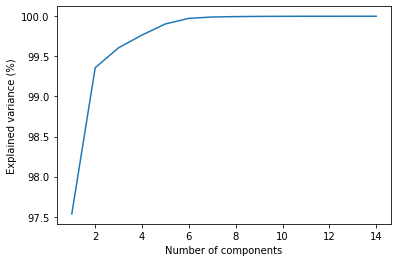

In [ ]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

####Aplicando o PCA

In [ ]:
pca_components = abs(pca.components_)

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

for row in range(pca_components.shape[0]): # get the indices of the top 4 values in each row
  temp = np.argpartition(-(pca_components[row]),6)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:6]

  # print the top 4 feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')


Cumulative Variances (Percentage):
[97.53544334 99.35805484 99.60696752]
Number of components: 3

The most important features in each component
Component 0: ['GT_C_airOut_pressure', 'HP_T_exit_pressure', 'GT_shaft_torque', 'GT_C_airOut_temp', 'S_prplr_torque', 'P_prplr_torque']
Component 1: ['GG_rpm', 'ship_speed', 'lever_position', 'T_inj_control', 'fuel_flow', 'GT_exhGas_pressure']
Component 2: ['T_inj_control', 'GT_rpm', 'HP_T_exit_temp', 'GT_exhGas_pressure', 'HP_T_exit_pressure', 'GT_C_airOut_pressure']


####Modelagem

In [ ]:
# Splitando os dados em traino e teste
X_pca2_train, X_pca2_test, y1_train, y1_test = train_test_split(X_pca,y1)

In [ ]:
# Aplicando os modelos
y1_models = train_models(X_pca2_train, y1_train, X_pca2_test, y1_test, models)
y1_models.drop(['Model'], axis=1)

[14:34:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train_Time,Train_Accuracy,Test_Accuracy
SVR,0.006246,-0.000003,-0.000023
KNeighborsRegressor,0.004828,0.988355,0.980333
DecisionTreeRegressor,0.039888,1.0,0.956269
BaggingRegressor,0.247848,0.995953,0.97748
XGBRegressor,0.350435,0.797358,0.773481


Consideramos menos vantajoso, pois precisa de bastante features

####Y2

In [ ]:
df_corr_y2 = df.corr()['GT_T_decay_coef'].abs().sort_values(ascending=False)
df_corr_y2

GT_T_decay_coef         1.000000e+00
HP_T_exit_temp          3.846390e-02
T_inj_control           1.887184e-02
GT_C_airOut_pressure    1.830336e-02
fuel_flow               1.732675e-02
GT_C_airOut_temp        1.685505e-02
GT_exhGas_pressure      1.179423e-02
GG_rpm                  1.000011e-02
HP_T_exit_pressure      2.718186e-03
GT_shaft_torque         3.576383e-04
S_prplr_torque          1.044235e-04
P_prplr_torque          1.044235e-04
GT_rpm                  1.776556e-05
GT_C_decay_coef         4.064242e-14
lever_position          8.566427e-17
ship_speed              9.367920e-18
Name: GT_T_decay_coef, dtype: float64

###PCA do Top VIF

In [ ]:
features = calculated_vif_y1[calculated_vif_y1['VIF'] < 500].index.to_list()
print('Features (VIF < 500):\n', features)

x1_pca_500 = X.loc[:, features]



Features (VIF < 500):
 ['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']


In [ ]:
# Performing Standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(x1_pca_500)

In [ ]:
components = 2
# None return the same number of original features in the dataset
# floating number between 0<n<1 return the number of components needed to capture the specified percentage of variability in the data
# an integer to indicate how many principal componentes you want to reduce the features to.

pca = PCA(n_components = components)

# Perform PCA on the scaled data
pca.fit(X_scaled)

print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)

Variances (Percentage):
[95.31759907  4.1212367 ]


Text(0, 0.5, 'Explained variance (%)')

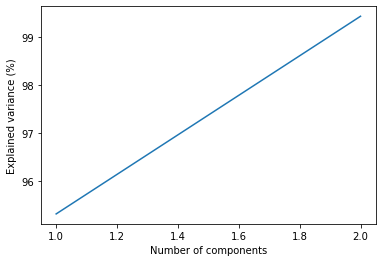

In [ ]:
components = len(pca.explained_variance_ratio_) if components is None else components
plt.plot(range(1, components+1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

####Aplicando o PCA

In [ ]:
pca_components = abs(pca.components_)
print(pca_components)

[[0.57537144 0.56895791 0.58756669]
 [0.62773132 0.76771713 0.12870039]]


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))

components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')

print('\nThe most important features in each component')

for row in range(pca_components.shape[0]): # get the indices of the top 4 values in each row
  temp = np.argpartition(-(pca_components[row]),2)
  # sort the indices in descending order
  indices = temp[np.argsort((-pca_components[row])[temp])][:]

  # print the top 4 feature names
  print(f'Component {row}: {df.columns[indices].to_list()}')

Cumulative Variances (Percentage):
[95.31759907 99.43883577]
Number of components: 2

The most important features in each component
Component 0: ['GT_shaft_torque', 'lever_position', 'ship_speed']
Component 1: ['ship_speed', 'lever_position', 'GT_shaft_torque']


####Modelagem

In [ ]:
#sc = StandardScaler()
#X_scaled = sc.fit_transform(x1_pca_500)

#pca = PCA(n_components=2)
#X_pca = pca.fit_transform(X_scaled)

# Splitando os dados em traino e teste
X_pca2_train, X_pca2_test, y1_train, y1_test = train_test_split(X_pca,y1)

Redução de Dimensão e PCA

In [ ]:
# Aplicando os modelos
y1_PCA2_500_models = train_models(X_pca2_train, y1_train, X_pca2_test, y1_test, models)
y1_PCA2_500_models.drop(['Model'], axis=1)

[15:28:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,Train_Time,Train_Accuracy,Test_Accuracy
SVR,0.002732,-0.000004,-0.000032
KNeighborsRegressor,0.005486,0.931793,0.918566
DecisionTreeRegressor,0.033026,1.0,0.852801
BaggingRegressor,0.208056,0.978771,0.904062
XGBRegressor,0.294209,0.653714,0.634156


Apenas a Redução de Dimensão

In [ ]:
y1_models_500.drop(['Model'], axis=1).drop(['Y Predicted Test'], axis=1)

,Train Time,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy (R²),Test Accuracy (R²)
SVR,0.003881,0.013022,0.000225,0.01499,-0.000162,-0.001386
KNeighborsRegressor,0.005749,0.000768,0.000006,0.002416,0.987019,0.973977
DecisionTreeRegressor,0.052414,0.001337,0.00001,0.0031,1.0,0.95718
BaggingRegressor,0.333189,0.000833,0.000006,0.002549,0.996361,0.971038
XGBRegressor,0.342907,0.00521,0.000046,0.006772,0.801908,0.795619


O resultado foi levemente menor.

Seguiremos com os modelos obtidos no y1_models_500 <br>
KNeighborsRegressor e BaggingRegressor

# Visualização das Predições

In [65]:
y1_pred_bagg_500 = y1_models_500['Y Predicted Test']['BaggingRegressor']
y1_pred_knn_500 = y1_models_500['Y Predicted Test']['KNeighborsRegressor']

In [50]:
x_columns_500 = list(x1_test_500)
x_columns_500

['T_inj_control', 'GG_rpm', 'HP_T_exit_temp']

In [76]:
def Graph_prediction2d(x_train, y_train, x_test, y_test, y_pred):

  for i, x in enumerate(x_train):
    fig = go.Figure([
        go.Scatter(x=x_train.iloc[:,i], y=y_train, name='Train', mode='markers'),
        go.Scatter(x=x_test.iloc[:,i], y=y_test, name='Test', mode='markers'),
        go.Scatter(x=x_test.iloc[:,i], y=y_pred, name='Prediction', mode='markers')
    ])

    fig.update_layout(title=X.columns[i] +  ' x Target',
                      
                        xaxis_title=X.columns[i],
                        yaxis_title='y',
                        
                      width=600, height=500)
    fig.show()

In [77]:
print('KNeighborsRegressor')
Graph_prediction2d(x1_train[x_columns_500], y1_train, x1_test[x_columns_500], y1_test, y1_pred_knn_500)

KNeighborsRegressor


In [54]:
print('BaggingRegressor')
Graph_prediction2d(x1_train[x_columns_500], y1_train, x1_test[x_columns_500], y1_test, y1_pred_bagg_500)

BaggingRegressor


https://github.com/plotly/plotly.py/issues/1085
https://www.google.com/search?q=go.Scatter3d+with+colorbar&source=lmns&bih=969&biw=1920&rlz=1C1GCEU_pt-PTBR940BR940&hl=pt-BR&sa=X&ved=2ahUKEwiowNjogcj6AhWNrJUCHY7nBtkQ_AUoAHoECAEQAA


In [60]:
def Graph_prediction3d(x, y_test, y_pred):
  x_ = x.iloc[:,0]
  z_ = x.iloc[:,1]
  y_ = x.iloc[:,2]

  # plotly data
  data=[go.Scatter3d(x=x_, y=y_, z=z_,mode='markers',
        marker=dict(
          size=7,
          color=y_test,
          #colorscale='Viridis',
          opacity=0.5,
          symbol='diamond')), # 'circle', 'circle-open', 'cross',
                      # 'diamond', 'diamond-open', 'square', 'square-open', 'x'

        go.Scatter3d(x=x_, y=y_, z=z_,mode='markers',
        marker=dict(
          size=5,
          color=y_pred,
          #colorscale='icefire',
          opacity=1,
          symbol='circle'))]

  fig = go.Figure(data)
  fig.update_layout(title='Main Features x Target',
                    scene=dict(
                    xaxis_title=X.columns[0],
                    yaxis_title=X.columns[1],
                    zaxis_title=X.columns[2]),          
                    width=700, height=700)

  fig.show()

In [61]:
print('KNeighborsRegressor')
Graph_prediction3d(x1_test[x_columns_500], y1_test, y1_pred_bagg_500)

KNeighborsRegressor


In [62]:
print('BaggingRegressor')
Graph_prediction3d(x1_test[x_columns_500], y1_test, y1_pred_bagg_500)

BaggingRegressor


In [64]:
import plotly.express as px

fig = px.scatter_3d(x=x1_test[x_columns_500].iloc[:,0], y=x1_test[x_columns_500].iloc[:,2], z=x1_test[x_columns_500].iloc[:,1],  color=y1_test)
fig.show()



# Aprimoramento dos Parâmetros

In [24]:
def metrics_models(x_train, y_train, x_test, y_test, models):
  y_info = pd.DataFrame(columns=['Model', 'Mean Absolute Error', 'Mean Absolute Percentual Error', 'Mean Squared  Error',
                                 'Root Mean Squared  Error','Train Accuracy (R²)', 'Test Accuracy (R²)', 'Y Predicted Test'], 
                       index = models.keys())
  
  for i, model in enumerate(models.keys()):
    y_pred = models[model].predict(x_test)
    
    y_info.loc[y_info.index[i], 'Model'] = models[model].fit(x_train, y_train)
    y_info.loc[y_info.index[i], 'Train Accuracy (R²)'] = models[model].score(x_train, y_train)
    y_info.loc[y_info.index[i], 'Test Accuracy (R²)'] = models[model].score(x_test, y_test)
    y_info.loc[y_info.index[i], 'Mean Absolute Error'] = mean_absolute_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Absolute Percentual Error'] = metrics.mean_absolute_percentage_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Mean Squared  Error'] = mean_squared_error(y_test, y_pred)
    y_info.loc[y_info.index[i], 'Root Mean Squared  Error'] = np.sqrt(mean_squared_error(y_test, y_pred))
    y_info.loc[y_info.index[i], 'Y Predicted Test'] = y_pred

  return y_info

##Y1

###KNN

In [41]:
param_grid_knn = {
    'n_neighbors': range(1,19,2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    #'algorithm': [auto, 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(15,40,5)
}

#### Grid Search

In [42]:
gs = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    verbose=1,
    cv = 3,
    n_jobs = -1
)

gs_knn_results = gs.fit(x1_train_500, y1_train)

Fitting 3 folds for each of 270 candidates, totalling 810 fits


####Bayesian Optimization

In [38]:
def objective_knn(trial):
  """return the R² Score"""
  x_train = x1_train_500
  y_train = y1_train
  x_test = x1_test_500
  y_test = y1_test
  # search space 
  param_obj_knn = {
      'n_neighbors': trial.suggest_int('n_neighbors', low=1, high=19, step=2),
      'leaf_size': trial.suggest_int('leaf_size', low=15, high=40, step=5),
      'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
      'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
  }

  knn = KNeighborsRegressor(**param_obj_knn)
  
  knn.fit(x_train, y_train)
  score = knn.score(x_test, y_test)
  return score

In [ ]:
# create a study (aim to maximize score)
study = optuna.create_study(sampler=TPESampler(), direction='maximize')

time_start = time.time()
study.optimize(objective_knn, n_trials=100)
time_bayesian = time.time() - time_start

In [43]:
default_knn_model = y1_models_500['Model']['KNeighborsRegressor']
gs_knn_model = gs_knn_results.best_estimator_

bay_knn_model = KNeighborsRegressor(**study.best_trial.params)
bay_knn_model.fit(x1_train_500, y1_train)

KNeighborsRegressor(n_neighbors=3, weights='distance')

In [44]:
pd.DataFrame([default_knn_model.get_params(),
              gs_knn_model.get_params(),
              bay_knn_model.get_params()],
              index=[
                  'KNN Default',
                  'KNN Grid Search',
                  'KNN Bayesian Optimization'])

,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
KNN Default,auto,30,minkowski,None,None,5,2,uniform
KNN Grid Search,auto,15,manhattan,None,None,3,2,distance
KNN Bayesian Optimization,auto,30,minkowski,None,None,3,2,distance


In [45]:
optuna.visualization.plot_param_importances(study)

In [46]:
models_knn = {
    'KNN Default': default_knn_model,
    'KNN Grid Search': gs_knn_model,
    'KNN Bayesian Optimization ': bay_knn_model
}

y1_metrics_models_knn = metrics_models(x1_train_500, y1_train, x1_test_500, y1_test, models_knn)
y1_metrics_models_knn.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

,Mean Absolute Error,Mean Absolute Percentual Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy (R²),Test Accuracy (R²)
KNN Default,0.000716,0.000735,0.000004,0.001949,0.985414,0.982677
KNN Grid Search,0.000679,0.000696,0.000003,0.001769,1.0,0.985723
KNN Bayesian Optimization,0.000622,0.000638,0.000003,0.001675,1.0,0.987197


###BaggingRegressor

In [26]:
param_grid_bagg = {
    'n_estimators': range(0,51,5),
    'max_samples' : [0.6, 0.8, 1.0],
    'max_features': [0.6, 0.8, 1.0],
    #'bootstrap': [True, False],
    #'oob_score': [True, False],
    #'bootstrap_features': [True, False],
    'warm_start': [True, False],
    #'base_estimator': [DecisionTreeRegressor()], #default = DecisionTreeRegressor
    #'base_estimator__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    #'base_estimator__splitter': ['best','random'],
    #'base_estimator__max_depth': range(1,13,2),
    #'base_estimator__min_samples_leaf': range(1,10,1),
    #'base_estimator__min_weight_fraction_leaf': [x * 0.1 for x in range(0, 11)],
    #'base_estimator__max_features': ['auto','log2','sqrt',None],
    #'base_estimator__max_leaf_nodes' : [None] + [*range(10,100,10)]
}

####Grid Search

In [18]:
gs = GridSearchCV(
    BaggingRegressor(),
    param_grid_bagg,
    verbose=1,
    cv = 3,
    n_jobs = -1
)

gs_bagg_results = gs.fit(x1_train_500, y1_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


####Bayesian Optimization

In [30]:
def objective_bagg(trial):
  """return the R² Score"""
  x_train = x1_train_500
  y_train = y1_train
  x_test = x1_test_500
  y_test = y1_test
  # search space
  param_obj_bagg = {
      'n_estimators': trial.suggest_categorical('n_estimators', range(1,51,5)),
      'max_samples' : trial.suggest_categorical('max_samples', [0.6, 0.8, 1.0]),
      'max_features': trial.suggest_categorical('max_features', [0.6, 0.8, 1.0]),

      'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
      #'oob_score': trial.suggest_categorical('oob_score', [True, False]),
      'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False]),
      'warm_start': trial.suggest_categorical('warm_start', [True, False]),

      #'base_estimator': trial.suggest_categorical('base_estimator', [DecisionTreeRegressor()]),
      #'base_estimator__criterion': trial.suggest_categorical('base_estimator__criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
      #'base_estimator__splitter': trial.suggest_categorical('base_estimator__splitter', ['best','random']),
      #'base_estimator__max_depth': trial.suggest_int('base_estimator__max_depth', low=1, high=13, step=2),
      #'base_estimator__min_samples_leaf': trial.suggest_int('base_estimator__min_samples_leaf', low=1, high=10, step=1),
      #'base_estimator__min_weight_fraction_leaf': trial.suggest_int('base_estimator__min_weight_fraction_leaf', low=0.1, high=1.0, step=0.1),
      #'base_estimator__max_features': trial.suggest_categorical('base_estimator__max_features', ['auto','log2','sqrt',None]),
      #'base_estimator__max_leaf_nodes' : trial.suggest_categorical('base_estimator__max_leaf_nodes', [None,10,20,30,40,50,60,70,80,90]) 

  }

  bagg = BaggingRegressor(**param_obj_bagg)
  
  bagg.fit(x_train, y_train)
  score = bagg.score(x_test, y_test)
  return score

In [ ]:
# create a study (aim to maximize score)
study_bagg = optuna.create_study(sampler=TPESampler(), direction='maximize')

time_start = time.time()
study_bagg.optimize(objective_bagg, n_trials=100)
time_bayesian_bagg = time.time() - time_start

In [33]:
default_bagg_model = y1_models_500['Model']['BaggingRegressor']
#default_bagg_model = BaggingRegressor()
#default_bagg_model.fit(x1_train_500, y1_train)

gs_bagg_model = gs_bagg_results.best_estimator_

bay_bagg_model = BaggingRegressor(**study_bagg.best_trial.params)
bay_bagg_model.fit(x1_train_500, y1_train)

BaggingRegressor(n_estimators=36, warm_start=True)

In [35]:
pd.DataFrame([default_bagg_model.get_params(),
              gs_bagg_model.get_params(),
              bay_bagg_model.get_params()
              ],
              index=[
                  'Bagging Default',
                  'Bagging Grid Search',
                  'Bagging Bayesian Optimization'
                  ])

,base_estimator,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
Bagging Default,None,True,False,1.0,1.0,10,None,False,None,0,False
Bagging Grid Search,None,True,False,1.0,1.0,15,None,False,None,0,True
Bagging Bayesian Optimization,None,True,False,1.0,1.0,36,None,False,None,0,True


In [36]:
models_bagg = {
    'Bagg Default': default_bagg_model,
    'Bagg Grid Search': gs_bagg_model,
    'Bagg Bayesian Optimization ': bay_bagg_model
}

y1_metrics_models_bagg = metrics_models(x1_train_500, y1_train, x1_test_500, y1_test, models_bagg)
y1_metrics_models_bagg.drop('Y Predicted Test', axis=1).drop('Model', axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:375: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:375: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  "Warm-start fitting without increasing n_estimators does not "


,Mean Absolute Error,Mean Absolute Percentual Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy (R²),Test Accuracy (R²)
Bagg Default,0.0008,0.000821,0.000004,0.001982,0.995334,0.982615
Bagg Grid Search,0.000752,0.000772,0.000004,0.001876,0.995937,0.983944
Bagg Bayesian Optimization,0.000712,0.000731,0.000003,0.001867,0.996567,0.984094


In [274]:
optuna.visualization.plot_param_importances(study_bagg)

#Conclusões

Modelos ordenados do melhor para o pior Test Accuracy (R²)

In [50]:
y1_metrics_models_knn.append(y1_metrics_models_bagg).drop('Y Predicted Test', axis=1).drop('Model', axis=1).sort_values('Test Accuracy (R²)', ascending=False)

,Mean Absolute Error,Mean Absolute Percentual Error,Mean Squared Error,Root Mean Squared Error,Train Accuracy (R²),Test Accuracy (R²)
KNN Bayesian Optimization,0.000622,0.000638,0.000003,0.001675,1.0,0.987197
KNN Grid Search,0.000679,0.000696,0.000003,0.001769,1.0,0.985723
Bagg Bayesian Optimization,0.000712,0.000731,0.000003,0.001867,0.996567,0.984094
Bagg Grid Search,0.000752,0.000772,0.000004,0.001876,0.995937,0.983944
KNN Default,0.000716,0.000735,0.000004,0.001949,0.985414,0.982677
Bagg Default,0.0008,0.000821,0.000004,0.001982,0.995334,0.982615


#Salvar o Modelo

MLOps